In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys
from jupyterthemes import jtplot

In [49]:
jtplot.style('default', grid=False)

# ALI minimum open time for 10 pulses, 1 bar GAr
 - Goal: estimate $t_{on}$ so that we deposit a mass $\delta m_{res}$ in a volume $\delta V$, i.e. reach a concentration $\rho$.
 - Inversely: from $\delta m_{deposit}$ (pressure curve), estimate density or concentration ($\rho, c$) we would have in $\delta V$ 

## Estimate maximum injected mass at the time for ~10 pulses, 1 bar GAr  

In [47]:
from ali.ali_sw import load_raw_ali_df
from ali.ali_sw import plot_pressure_curve
from ali.ali_sw import peaks_and_troughs
from ali.ali_sw import leaked_mass
from ali.ali_sw import plot_leak_distributions

## Run 1
 - p$_{Ar}$ = 1000 mbar
 - t$_{on}$ = 10 ms
 - 30 pulses

In [50]:
df = load_raw_ali_df('../sabatsw/ali/ali_data/28032019_methanol_1000mbar_10ms_30pulses')

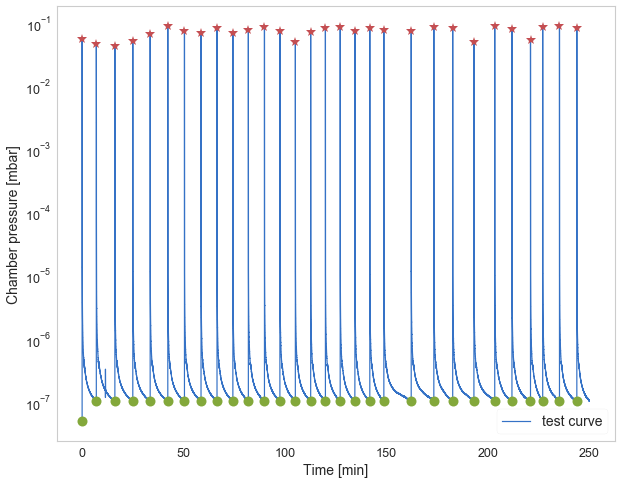

In [51]:
peaks, troughs = plot_pressure_curve(df, tit='test curve')

In [59]:
df.p_chamber[troughs[7]-1+np.where(df.p_chamber[troughs[7]:peaks[7]] >= 2e-7)[0]]

351780    1.040000e-07
351781    7.355730e-04
351782    1.004863e-02
351783    1.014324e-02
351784    6.408485e-03
351785    2.095410e-04
351786    2.335561e-02
351787    3.093754e-02
351788    4.254611e-02
351789    5.583220e-02
351790    6.365936e-02
Name: p_chamber, dtype: float64

In [63]:
troughs[7] += np.where(df.p_chamber[troughs[7]:peaks[7]] >= 2e-7)[0][0] - 1

In [67]:
troughs[7] -= 1

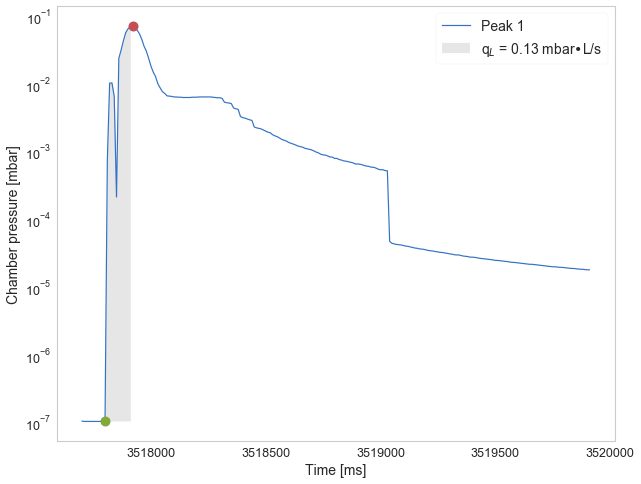

In [68]:
plot_pressure_curve(df[troughs[7]-10:peaks[7]+200], tit='Peak 1', scale='ms', flag_p=False)

plt.plot(troughs[7]*10, df.p_chamber[troughs[7]], 'o', markersize=10)
plt.plot(peaks[7]*10, df.p_chamber[peaks[7]], 'o', markersize=10)
plt.xlabel('Time [ms]', fontsize=14)
_,_, q,_ = leaked_mass(df, peaks, troughs, )

x=df.index[troughs[7] : peaks[7]]*10
plt.fill_between(x, df.p_chamber[troughs[7]], df.p_chamber[troughs[7]:peaks[7]],  color='0.9', label='q$_L$ = %.2f mbar•L/s'%q[7])
plt.legend(loc='best', fontsize=14)

In [47]:
def zoom_peak(peak_id : int, 
             df : pd.DataFrame,
             peaks : np.array, troughs : np.array,
             xrange : int = 900):
    """Use plot_pressure_curve focused on a specific peak index (peak_id) 
    and specify time range (default 900 s)"""
    plot_pressure_curve(df[troughs[peak_id]:peaks[peak_id]+xrange], tit='Peak '+str(peak_id), scale='s', flag_p=False)
    plt.plot(troughs[peak_id]/100, df.p_chamber[troughs[peak_id]], 'o', markersize=10)
    plt.plot(peaks[peak_id]/100, df.p_chamber[peaks[peak_id]], 'o', markersize=10)


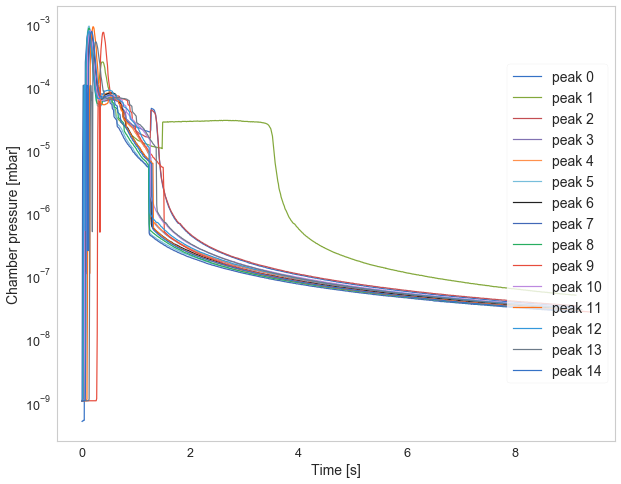

In [69]:
sc = 100
scale = 's'
xrange = 900
plt.figure(figsize=(10,8))

for i in range(len(peaks)-15):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    plt.plot(x, y, '-', label='peak '+str(i));

    plt.xlabel('Time ['+scale+']', fontsize=14)
    plt.yscale('log')
    plt.ylabel('Chamber pressure [mbar]', fontsize=14)
    plt.legend(loc='right',fontsize=14)

### Project peaks in 3d 

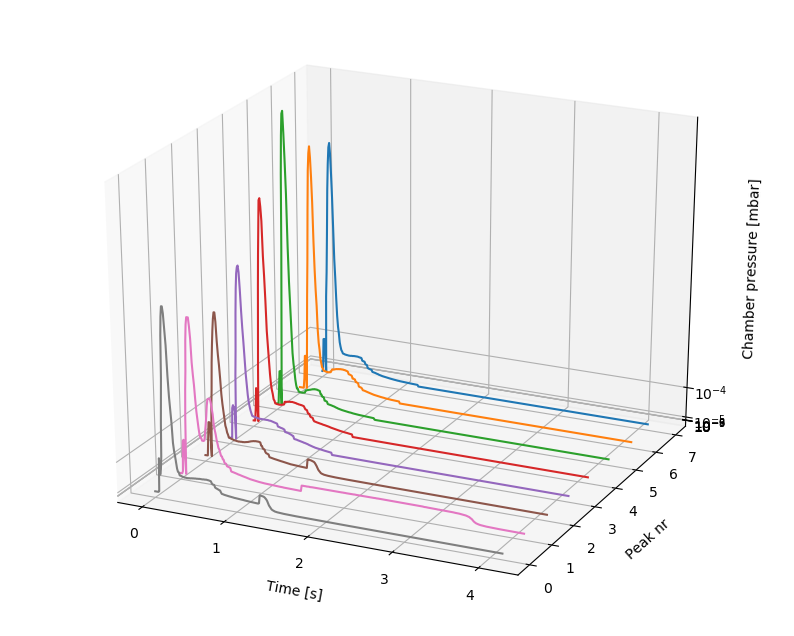

In [70]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

style.use('default')
sc = 100
scale = 's'
xrange = 400
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in range(7,-1,-1):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    ax.plot(x, y, zs=i, zdir='y', label='peak '+str(i));

    ax.set_xlabel('\nTime ['+scale+']')#, linespacing=3)
    ax.set_zscale('log')
    ax.set_zlabel('\nChamber pressure [mbar]')
    ax.set_ylabel('\nPeak nr')

#     ax.legend(loc='right',fontsize=14)
ax.view_init(elev=25., azim=-65)
plt.savefig('overlap_peaks3d.png', dpi=100)
plt.show()

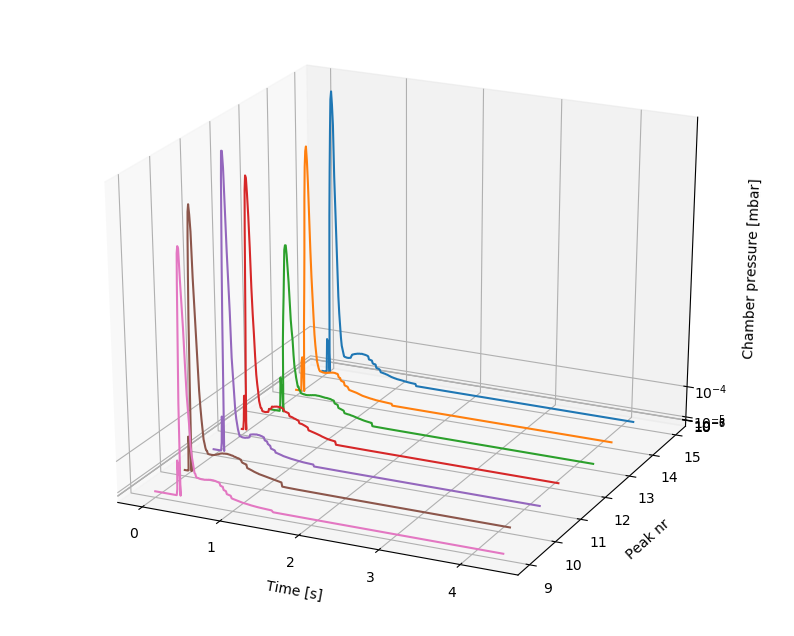

In [160]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

style.use('default')
sc = 100
scale = 's'
xrange = 400
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in range(15,8,-1):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    ax.plot(x, y, zs=i, zdir='y', label='peak '+str(i));

    ax.set_xlabel('\nTime ['+scale+']')#, linespacing=3)
    ax.set_zscale('log')
    ax.set_zlabel('\nChamber pressure [mbar]')
    ax.set_ylabel('\nPeak nr')

#     ax.legend(loc='right',fontsize=14)
ax.view_init(elev=25., azim=-65)
plt.savefig('overlap_peaks3d.png', dpi=100)
plt.show()

#####  Pumping speed for methanol
$$ S = A_P C' \sigma $$
$A_P$ : Aperture area
C' : conductance per surface area
$\sigma$ : capture probability

from https://indico.cern.ch/event/471931/contributions/1149644/attachments/1226014/1794773/JUAS_Vacuum_Technology.pdf slide 46

#####  Leak rate q$_L$
$$ q_L = S_{efec} \int_{t_1}^{t_1+\Delta t} P(t) \mathrm{d}t = \frac{\Delta(p \cdot V)}{\Delta t} = \frac{R\cdot T}{M} \cdot \frac{\Delta m}{\Delta t} $$

$S_{efec}$ : Effective pumping speed (L/s)

$R$ : Gas constant (83.144598 L⋅mbar/K⋅mol)

$M$ : Molar mass (32.041 g/mol for methanol)

$\Delta m$ : leaked mass (g)
From https://doi.org/10.1063/1.4964434

##### Leaked mass $\Delta m$
$$ \Delta m_{tot} = q_L \cdot \Delta t \frac{M}{RT} $$

In [101]:
delta_m, q, delta_t, error_delta_m = leaked_mass(df, peaks, troughs, M = 32.041, Seff=71)

delta_m

array([0.00393087, 0.00382445, 0.00369756, 0.00471314, 0.0044948 ,
       0.00577679, 0.00581936, 0.00459521, 0.00521024, 0.01243837,
       0.00538924, 0.00699725, 0.00378951, 0.00591965, 0.00669834,
       0.00619897, 0.00478574, 0.00454128, 0.00430216, 0.00434961,
       0.00452013, 0.00571956, 0.00610394, 0.00342581, 0.00492976,
       0.00597134, 0.00423518, 0.00555692, 0.00602884, 0.00559959])

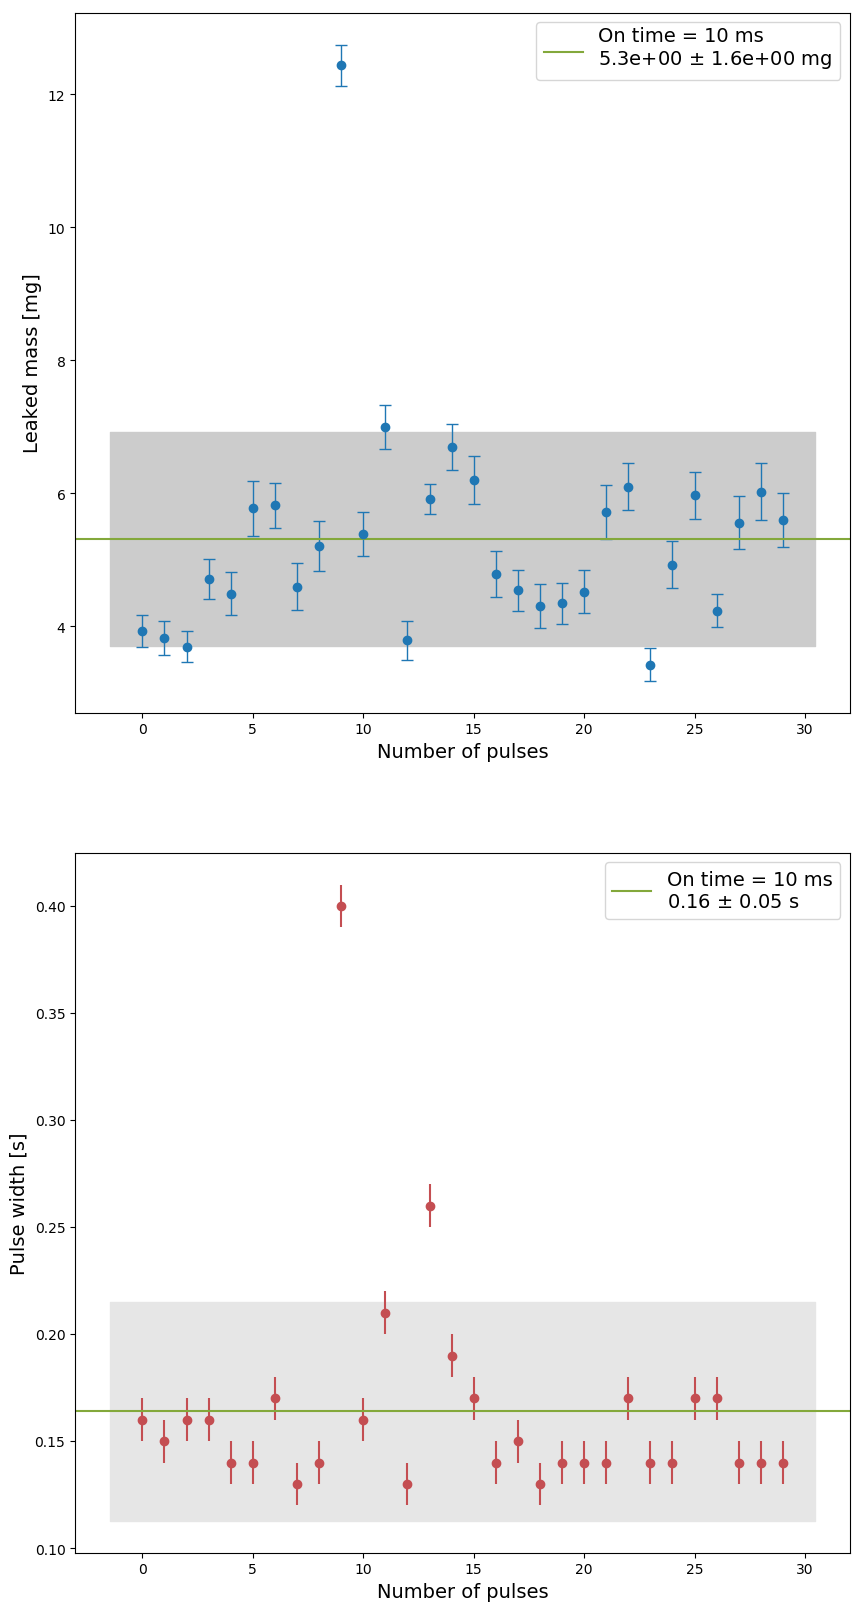

In [102]:
av_m, sd_m, _, _ = plot_leak_distributions(delta_m, error_delta_m, delta_t, label='10')

### How long does the solution last?

In [104]:
M = 32.041
av_ntot = av_m/M
sd_ntot = sd_m/M

V_inj = 0.3 # mL

0.00016599942524460446

## Run 2: fluorescein
 - p$_{Ar}$ = 1000 mbar
 - t$_{on}$ = 10 ms
 - 10 pulses

In [77]:
df2 = load_raw_ali_df('../sabatsw/ali/ali_data/22032019_fluorescein_1000mbar_10ms_10pulses_au')
peaks_and_troughs(df2.p_chamber)

(array([   111,  45638, 150217, 258075, 309687, 358980, 420701, 475352,
        541494]),
 array([    99,  45626, 150202, 258062, 309670, 358967, 420683, 475337,
        541479]))

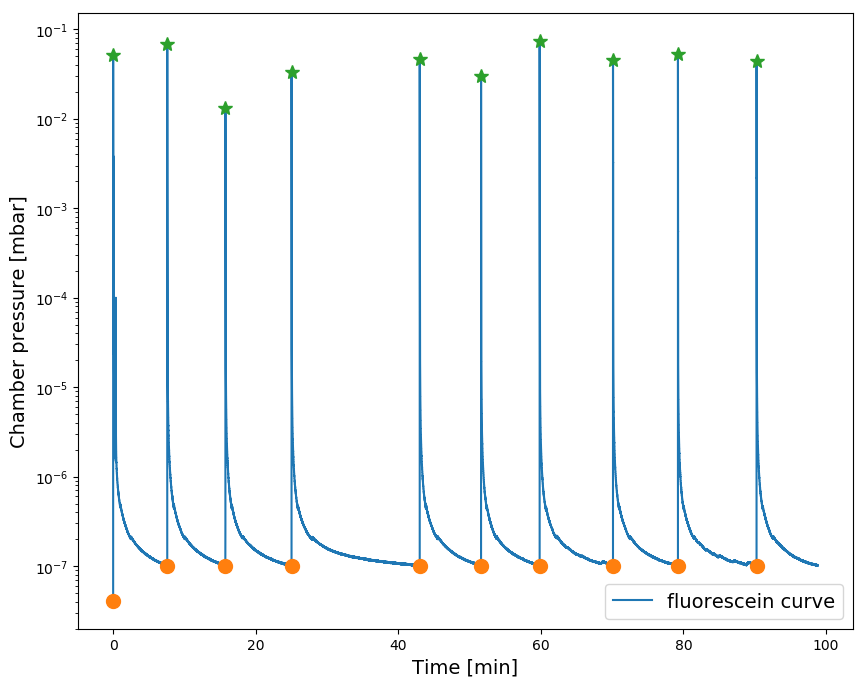

In [79]:
pflu, tflu = plot_pressure_curve(df2, tit='fluorescein curve')

In [81]:
delta_m, q, delta_t, error_delta_m = leaked_mass(df2, pflu, tflu, M = 32.041)

delta_m

array([0.00258526, 0.00350586, 0.00342066, 0.00289294, 0.0029112 ,
       0.00353925, 0.00395316, 0.0038422 , 0.00414747, 0.00339714])

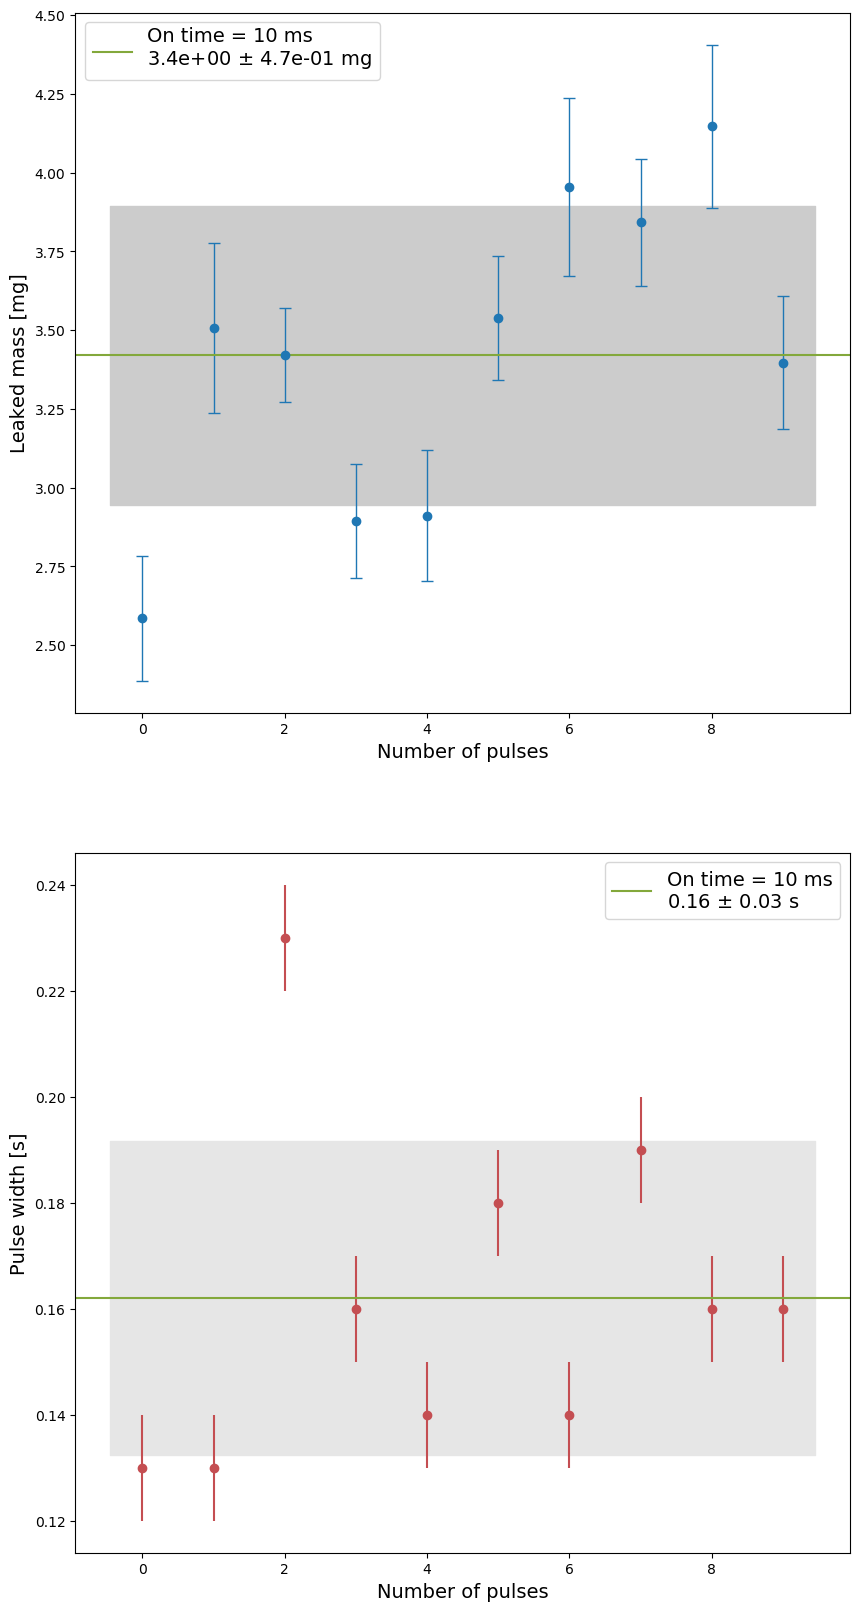

In [83]:
av_m, sd_m, _, _ = plot_leak_distributions(delta_m, error_delta_m, delta_t, label='10')

### Estimate fluorescein (solute) mass injection
$$ q_L = R T \frac{\Delta n_{tot}}{\Delta t} $$

$$ \Delta n_{tot} = \frac{q_L\cdot \Delta t}{RT} = \Delta n_{meth} + \Delta n_{fluo} = \Delta n_{fluo} \left(1+\frac{\Delta V_{meth}\cdot\rho_{meth}/M_{meth}}{\Delta n_{fluo}}\right) = \Delta n_{fluo} \left(1 + \frac{\rho_{meth}}{C\cdot M_{meth}}\right) $$

$C$ : solution concentration = 0.5 mmol/L

$M_{meth}$ : methanol molar mass = 32.041 g/mol

$\rho_{meth}$ : mass density = 792 g/L

$$ \Delta n_{fluo} = \frac{q_L\cdot \Delta t}{RT \left(1+\frac{\rho_{meth}}{C M_{meth}}\right)} $$

In [105]:
def nsolute(q : np.array, delta_t : np.array, df:pd.DataFrame, rho : float = 792.0, M : float = 32.041, C : float = 0.5):
    logtime = (df.datetime[1]-df.datetime[0]).total_seconds() # [10 ms]
    T = df.t_valve[0]+273 # Pulse valve temperature [K]
    R = 83.144598
    
    ntot = q*delta_t/(R*T)
    av_tot = np.average(ntot)
    sd_tot = np.std(ntot)
    
    nsol = q*delta_t/(R*T * (1 + rho/(C * M)))
    av_nsol = np.average(nsol)
    sd_nsol = np.std(nsol)
    
    return [av_nsol, sd_nsol, av_ntot, sd_ntot]

In [109]:
av_nfluo, sd_nfluo, av_ntot, sd_ntot = nsolute(q, delta_t, df)
print ('%.2e +-%.2e mol' %(av_nfluo, sd_nfluo))

3.29e-06 +-9.98e-07 mol


In [110]:
M_fluo = 331.3 #g/mol
print('%.2e +- %.2e g'%(av_nfluo*M_fluo, sd_nfluo*M_fluo))

1.09e-03 +- 3.30e-04 g


#####  From here we estimate the mole fractions:
$$ x_{fluo} = \frac{n_{fluo}}{n_{tot}} \qquad x_{meth} = 1-x_{fluo}$$

In [116]:
x_fluo = av_nfluo/av_ntot
x_fluo, 1-x_fluo

(0.01982684845248357, 0.9801731515475164)

##### Compute average density and molar mass
$$ \bar{M} = \sum_i x_i M_i \qquad  \bar{\rho} = \sum_i x_i \rho_i$$

$$ n_{batch} = \frac{\bar{\rho}}{\bar{M}} V_{batch} $$

In [120]:
M_meth = 32.041 # g/mol
rho_meth = 792.0 # g/L
rho_fluo = 1602.0 # g/L
M_mix = x_fluo*M_fluo + (1-x_fluo)*M_meth
rho_mix = x_fluo*rho_fluo + (1-x_fluo)*rho_fluo

V_batch = 0.3e-3 # L
n_batch = rho_mix/M_mix * V_batch
n_batch

0.012655906881486344

#####  Then the minimum number of pulses we need to deplete the batch is
$$ N_{pulses}^{(min)} = \frac{n_{batch}}{n_{pulse}} $$

In [121]:
n_batch/av_ntot

76.24066687482524

In [124]:
av_ntot

0.00016599942524460446

# Result

In [125]:
print("Typical leak mass: %.1e +- %.1e g" %(av_m, sd_m))

Typical leak mass: 5.3e-03 +- 1.6e-03 g


In [52]:
av_m/0.166155*1e3

0.257394611551979

## Other stuff: pumping speed
First approx. (no vapor pressure taken into account)

In [107]:
len(np.where(df2.valve.values != 0)[0])

10

In [50]:
avg/1e-3, sd*1e3, np.average(error_delta_m)*1e3

(0.026358223836644674, 0.00403068162584347, 0.0017622614319262179)

#####  Argon pumping speed
$Q_P = \frac{1}{4}A_Pn<v>\sigma$ = 0.54 mbar•l/s

$S_{eff}$ = 66 l/s

$S = Q_P/P = A_P C' \sigma$

$C' (273K) = \frac{1}{4} <v> = 9.85 $ l/(s•cm$^2$)

$A_P$ (CF 40) = 62.3 cm$^2$

##### Assuming $\sigma$ = 1, i.e. total capture probability:

In [35]:
A = np.pi/4*63**2/100 # DN 63 mm^2 -> cm^2
v = 4*9.85
C = v/4
S = A*C
S, v

(307.0486630866605, 39.4)

#####  Which agrees with the result in 
https://indico.cern.ch/event/471931/contributions/1149644/attachments/1226014/1794773/JUAS_Vacuum_Technology.pdf slide 47
From this we can conclude that $S_{eff} \neq  S$ and we can estimate $\sigma = S_{eff}/S = 0.21$ 

In [42]:
Seff = 66
sigma = Seff/S
sigma

0.21494964132565644

#####  This probability does not have to coincide with that of methanol, but we will assume it does for the moment

In [38]:
R = 83.144598
M = 32.041
T = 273

v_meth = np.sqrt(8*R*T/(np.pi*M))
v_meth

42.47323774458813

In [44]:
S_meth = A*v_meth/4
Seff_meth = S_meth*sigma
S_meth, Seff_meth

(330.9987529552709, 71.14806322697504)

##### This should make sense keeping in mind that the molecular mass of methanol is lighter than that of Argon

However this assumes, as said, that the methanol behaves immediately as an ideal gas following the Boltzmann distribution for thermal velocity and that the capture rate is the same as for Argon, which I doubt, methanol should be more reactive